In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from yellowbrick.classifier import confusion_matrix
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

In [219]:
df = pd.read_csv('../data/socio.csv')

In [220]:
df['_id'].value_counts()

_id
2       1
4964    1
4981    1
4980    1
4979    1
       ..
43      1
41      1
40      1
34      1
4999    1
Name: count, Length: 4999, dtype: int64

In [221]:
df.columns

Index(['_id', 'tempo_de_assinatura', 'historico_de_presenca_nos_jogos',
       'historico_de_socio', 'numero_de_desistencias_no_periodo',
       'historico_de_preco_nos_planos', 'tipo_de_plano', 'quantos_membros',
       'planos_com_ingresso_incluso', 'estado_civil', 'risco_de_churn',
       'feedback_sobre_servicos', 'frequencia_de_compra_de_produtos',
       'tipo_pagamento', 'recorrencia', 'renda_mensal', 'aprovacao_cartao'],
      dtype='object')

In [222]:
df['risco_de_churn'] = df['risco_de_churn'].replace('medio', 'médio')
df['risco_de_churn'] = df['risco_de_churn'].replace({'baixo': 0, 'médio': 1, 'alto': 1})

df['risco_de_churn']

/tmp/ipykernel_1896/3704502724.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['risco_de_churn'] = df['risco_de_churn'].replace({'baixo': 0, 'médio': 1, 'alto': 1})


0       1
1       1
2       1
3       1
4       1
       ..
4994    1
4995    1
4996    1
4997    1
4998    1
Name: risco_de_churn, Length: 4999, dtype: int64

In [223]:
media_cac = 3
desvio_padrao_percentual = 0.01
desvio_padrao = media_cac * desvio_padrao_percentual
np.random.seed(42)  # Para garantir reproducibilidade
df['CAC'] = np.random.normal(loc=media_cac, scale=desvio_padrao, size=len(df))

In [224]:
df['LTV'] = (df['tempo_de_assinatura']/10)*df['historico_de_preco_nos_planos']

In [225]:
estatisticas_descritivas = df['tempo_de_assinatura'].describe()

# Acessar os quartis diretamente a partir do resultado
q1 = estatisticas_descritivas['25%']
mediana = estatisticas_descritivas['50%']
q3 = estatisticas_descritivas['75%']

print("Primeiro quartil (Q1):", q1)
print("Mediana:", mediana)
print("Terceiro quartil (Q3):", q3)

Primeiro quartil (Q1): 22.0
Mediana: 43.0
Terceiro quartil (Q3): 65.0


In [226]:
df['expected_payments'] = ((q3 - df['tempo_de_assinatura'])/10) *df['historico_de_preco_nos_planos']

In [228]:
df['ROI'] = (df['LTV']-df['CAC'])/df['CAC']

In [230]:
df.columns

Index(['_id', 'tempo_de_assinatura', 'historico_de_presenca_nos_jogos',
       'historico_de_socio', 'numero_de_desistencias_no_periodo',
       'historico_de_preco_nos_planos', 'tipo_de_plano', 'quantos_membros',
       'planos_com_ingresso_incluso', 'estado_civil', 'risco_de_churn',
       'feedback_sobre_servicos', 'frequencia_de_compra_de_produtos',
       'tipo_pagamento', 'recorrencia', 'renda_mensal', 'aprovacao_cartao',
       'CAC', 'LTV', 'expected_payments', 'ROI'],
      dtype='object')

In [233]:
X = df.drop(['risco_de_churn','_id','estado_civil','renda_mensal'], axis=1)
y=df['risco_de_churn']

In [132]:
# colunas_numericas = X.select_dtypes(include=['float64', 'int64']).columns
# scaler = RobustScaler()
# X[colunas_numericas] = scaler.fit_transform(X[colunas_numericas])
# X

,tempo_de_assinatura,historico_de_presenca_nos_jogos,historico_de_socio,numero_de_desistencias_no_periodo,historico_de_preco_nos_planos,tipo_de_plano,quantos_membros,planos_com_ingresso_incluso,estado_civil,feedback_sobre_servicos,frequencia_de_compra_de_produtos,tipo_pagamento,recorrencia,renda_mensal
0,-0.093023,0.891892,-0.368421,-0.2,-0.457490,familiar,0.00,sim,solteiro,-0.333333,-0.833333,boleto,False,2501-5000
1,0.209302,0.594595,-0.894737,-0.8,-0.113360,familiar,-0.25,sim,divorciado,-0.666667,-0.333333,pix,False,2501-5000
2,-0.325581,-0.486486,-0.736842,-0.4,0.761134,individual,0.00,nao,casado,-0.166667,0.000000,pix,False,1501-2500
3,-0.651163,1.189189,-0.526316,-0.8,0.562753,individual,0.00,sim,solteiro,-0.500000,0.833333,pix,False,1501-2500
4,0.000000,1.297297,-0.789474,-0.4,-0.032389,individual,-0.75,sim,casado,0.500000,-0.500000,boleto,False,0-1500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,-0.418605,0.459459,0.684211,-1.0,0.064777,individual,0.25,sim,divorciado,-0.166667,-0.333333,cartão de débito,True,1501-2500
4995,0.697674,0.486486,-0.684211,0.2,-0.145749,individual,0.00,nao,solteiro,0.833333,1.500000,boleto,False,2501-5000
4996,-0.976744,0.108108,0.263158,-0.4,-0.514170,familiar,-0.25,sim,solteiro,0.666667,-0.333333,cartão de crédito,True,1501-2500
4997,-0.930233,0.081081,-0.105263,-0.2,-0.740891,individual,0.00,sim,divorciado,-0.666667,0.000000,boleto,False,1501-2500


In [133]:
# colunas_categoricas = df.select_dtypes(include=['object']).columns

In [134]:
# ohe = OneHotEncoder()
# X_encoded = ohe.fit_transform(X[colunas_categoricas])
# X_encoded = pd.DataFrame(X_encoded.toarray(), columns=ohe.get_feature_names_out(colunas_categoricas))
# X = pd.concat([X, X_encoded], axis=1).drop(colunas_categoricas, axis=1)

In [135]:
# X

,tempo_de_assinatura,historico_de_presenca_nos_jogos,historico_de_socio,numero_de_desistencias_no_periodo,historico_de_preco_nos_planos,quantos_membros,feedback_sobre_servicos,frequencia_de_compra_de_produtos,recorrencia,tipo_de_plano_familiar,...,tipo_pagamento_boleto,tipo_pagamento_cartão de crédito,tipo_pagamento_cartão de débito,tipo_pagamento_pix,renda_mensal_0-1500,renda_mensal_10001-20000,renda_mensal_1501-2500,renda_mensal_20001+,renda_mensal_2501-5000,renda_mensal_5001-10000
0,-0.093023,0.891892,-0.368421,-0.2,-0.457490,0.00,-0.333333,-0.833333,False,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.209302,0.594595,-0.894737,-0.8,-0.113360,-0.25,-0.666667,-0.333333,False,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.325581,-0.486486,-0.736842,-0.4,0.761134,0.00,-0.166667,0.000000,False,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.651163,1.189189,-0.526316,-0.8,0.562753,0.00,-0.500000,0.833333,False,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.000000,1.297297,-0.789474,-0.4,-0.032389,-0.75,0.500000,-0.500000,False,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,-0.418605,0.459459,0.684211,-1.0,0.064777,0.25,-0.166667,-0.333333,True,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4995,0.697674,0.486486,-0.684211,0.2,-0.145749,0.00,0.833333,1.500000,False,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4996,-0.976744,0.108108,0.263158,-0.4,-0.514170,-0.25,0.666667,-0.333333,True,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4997,-0.930233,0.081081,-0.105263,-0.2,-0.740891,0.00,-0.666667,0.000000,False,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [232]:
def model_evaluation(y_pred,y_test,y_train,x_train,x_test,model):
    '''
    This function aims to show the main model evaluation metrics (accuracy, recall, precision and f1), as well as the confusion matrix.
    '''
    # Accuracy: The overall percentage of correct predictions made by the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Acuracy: {accuracy:.4f}. (The overall percentage of correct predictions made by the model)')

    # Precision: The ratio of correct positive predictions to the total positive predictions made by the model
    precision = precision_score(y_test, y_pred)
    print(f'Precision: {precision:.4f}(The ratio of correct positive predictions to the total positive predictions made by the model)')

    # Recall: The ratio of correct positive predictions to the total actual positive cases
    recall = recall_score(y_test, y_pred)
    print(f'Recall: {recall:.4f} (The ratio of correct positive predictions to the total actual positive cases.)')

    # F1-score: A metric that combines precision and recall into a single measure, useful when there is an imbalance between classes
    f1 = f1_score(y_test, y_pred)
    print(f'F1-score: {f1:.4f} ( A metric that combines precision and recall into a single measure, useful when there is an imbalance between classes)')

    #Confusion metrix
    cm = confusion_matrix(model,x_train,y_train,x_test,y_test)
    cm.show;

In [137]:
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

Acuracy: 0.6540. (The overall percentage of correct predictions made by the model)
Precision: 0.6540(The ratio of correct positive predictions to the total positive predictions made by the model)
Recall: 1.0000 (The ratio of correct positive predictions to the total actual positive cases.)
F1-score: 0.7908 ( A metric that combines precision and recall into a single measure, useful when there is an imbalance between classes)


/home/giovane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


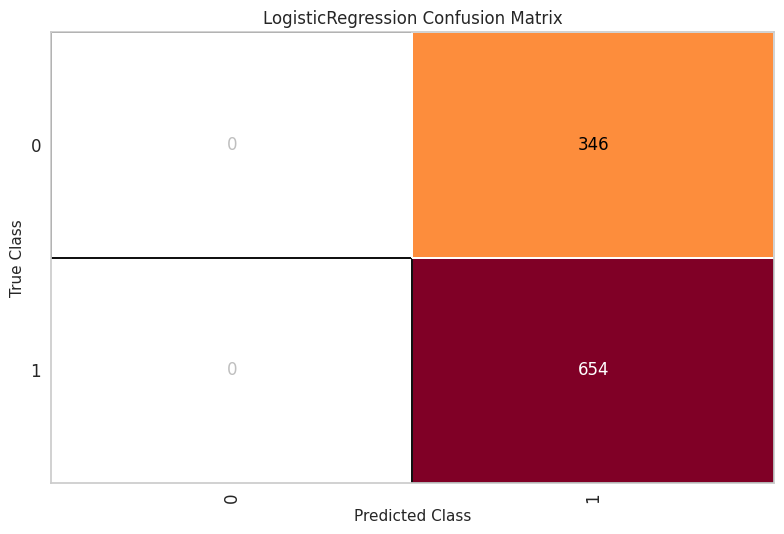

In [138]:
# lg= LogisticRegression()
# lg.fit(x_train, y_train)

# # Making predictions
# y_pred = lg.predict(x_test)

# # Evaluating the model
# model_evaluation(y_pred,y_test,y_train,x_train,x_test,lg)

Acuracy: 0.5890. (The overall percentage of correct predictions made by the model)
Precision: 0.6544(The ratio of correct positive predictions to the total positive predictions made by the model)
Recall: 0.7875 (The ratio of correct positive predictions to the total actual positive cases.)
F1-score: 0.7148 ( A metric that combines precision and recall into a single measure, useful when there is an imbalance between classes)


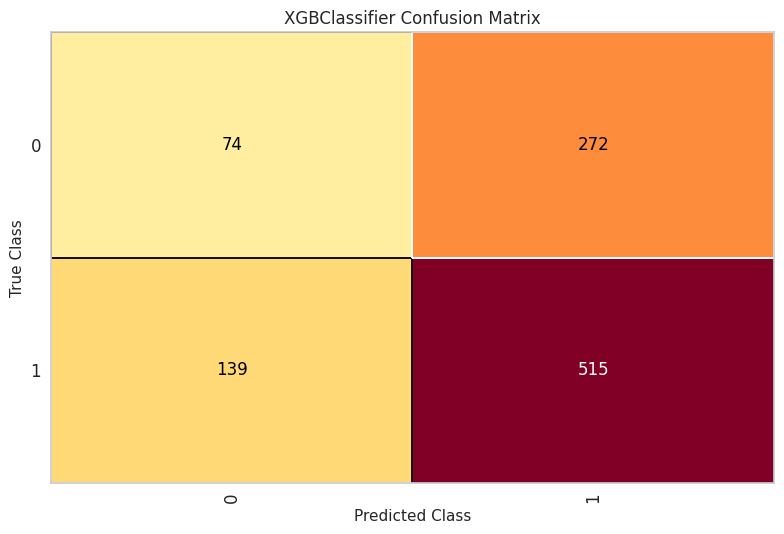

In [139]:

# model_xgb = XGBClassifier(objective='binary:logistic',  random_state=42)

# model_xgb.fit(x_train, y_train)

# y_pred = model_xgb.predict(x_test)

# model_evaluation(y_pred,y_test,y_train,x_train,x_test,model_xgb)

In [140]:
# y_pred = model_xgb.predict_proba(x_test)
# y_pred

array([[0.36318892, 0.6368111 ],
       [0.02185953, 0.9781405 ],
       [0.24392623, 0.7560738 ],
       ...,
       [0.7914703 , 0.20852971],
       [0.37714726, 0.62285274],
       [0.533489  , 0.46651098]], dtype=float32)

In [141]:
# param_grid = {
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 4, 5],
# }
# xgb_model = XGBClassifier()

# # Crie um objeto GridSearchCV
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5)

# # Ajuste o modelo aos dados de treinamento
# grid_search.fit(x_train, y_train)

# # Obtenha os melhores hiperparâmetros encontrados
# best_params = grid_search.best_params_

# # Obtenha o modelo com os melhores hiperparâmetros
# best_xgb_model = grid_search.best_estimator_

# # Faça previsões no conjunto de teste
# y_pred = best_xgb_model.predict(x_test)

# # Avalie o desempenho do modelo
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Acurácia no conjunto de teste: {accuracy:.4f}')

# # Exiba os melhores hiperparâmetros encontrados
# print("Melhores hiperparâmetros:")
# print(best_params)

Acuracy: 0.5440. (The overall percentage of correct predictions made by the model)
Precision: 0.6523(The ratio of correct positive predictions to the total positive predictions made by the model)
Recall: 0.6483 (The ratio of correct positive predictions to the total actual positive cases.)
F1-score: 0.6503 ( A metric that combines precision and recall into a single measure, useful when there is an imbalance between classes)


/home/giovane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/giovane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


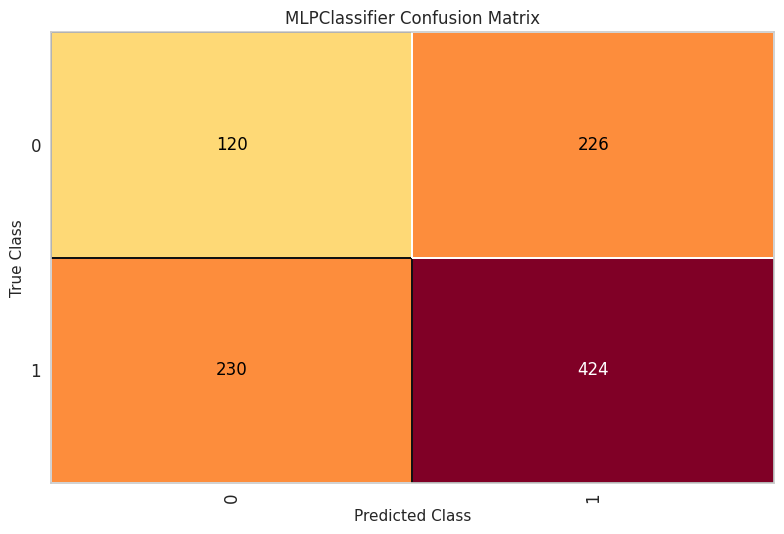

In [142]:
# model_nn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# model_nn.fit(x_train, y_train)

# y_pred = model_nn.predict(x_test)

# model_evaluation(y_pred,y_test,y_train,x_train,x_test,model_nn)

Acuracy: 0.6390. (The overall percentage of correct predictions made by the model)
Precision: 0.6518(The ratio of correct positive predictions to the total positive predictions made by the model)
Recall: 0.9618 (The ratio of correct positive predictions to the total actual positive cases.)
F1-score: 0.7770 ( A metric that combines precision and recall into a single measure, useful when there is an imbalance between classes)


/home/giovane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


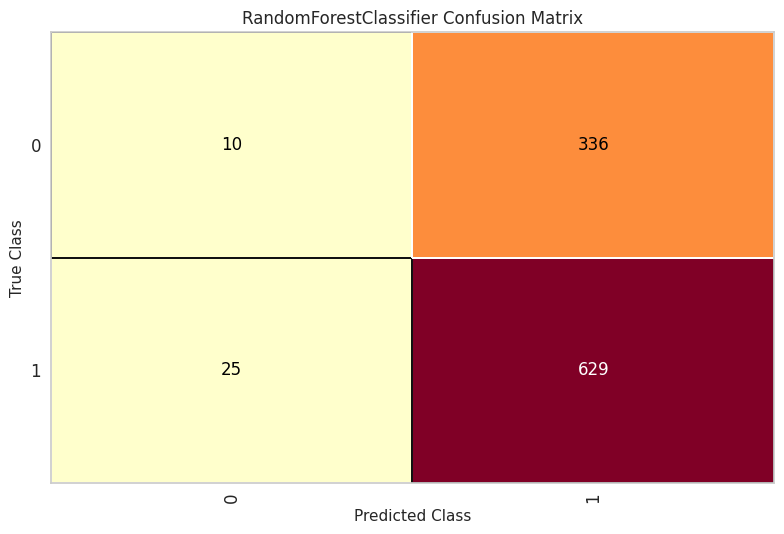

In [143]:
# rf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf.fit(x_train, y_train)

# # Making predictions
# y_pred = rf.predict(x_test)

# # Evaluating the model
# model_evaluation(y_pred,y_test,y_train,x_train,x_test,rf)

Acuracy: 0.6540. (The overall percentage of correct predictions made by the model)
Precision: 0.6540(The ratio of correct positive predictions to the total positive predictions made by the model)
Recall: 1.0000 (The ratio of correct positive predictions to the total actual positive cases.)
F1-score: 0.7908 ( A metric that combines precision and recall into a single measure, useful when there is an imbalance between classes)


/home/giovane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


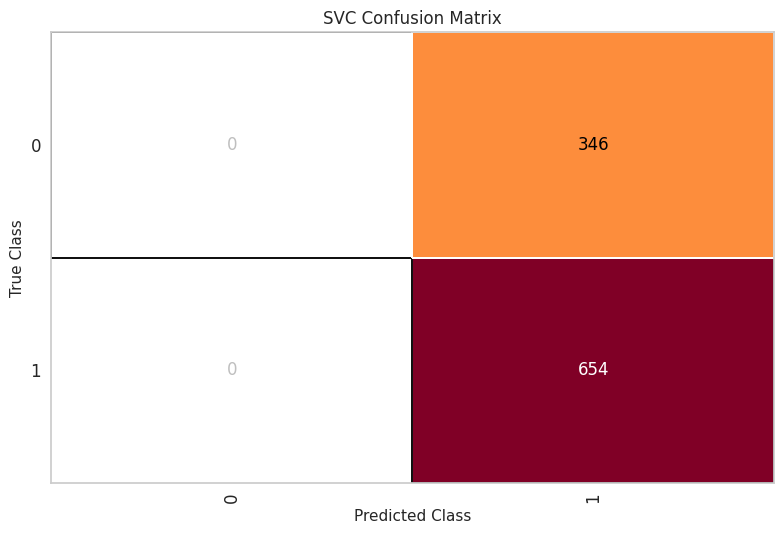

In [144]:
# model_svm = svm.SVC(kernel='linear')
# model_svm.fit(x_train, y_train)

# y_pred = model_svm.predict(x_test)

# model_evaluation(y_pred,y_test,y_train,x_train,x_test,model_svm)

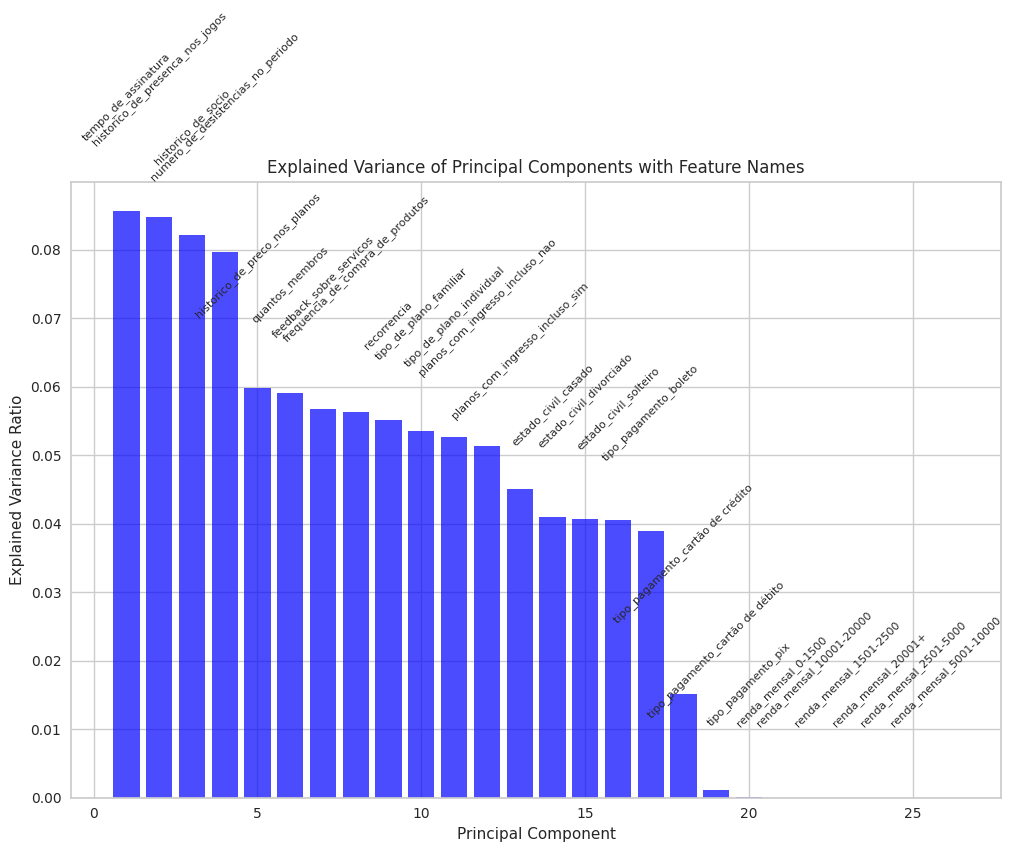

In [145]:
# Apply Principal Component Analysis (PCA) to reduce dimensionality
pca = PCA()
X_pca = pca.fit_transform(X)

# Retrieve the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Create a DataFrame to store principal component, explained variance ratio, and corresponding feature names
df_var_exp = pd.DataFrame({'Principal Component': range(1, len(explained_variance_ratio) + 1),
                            'Explained Variance Ratio': explained_variance_ratio,
                            'Feature': X.columns})

# Create a bar plot to visualize the explained variance of each principal component with feature names
plt.figure(figsize=(12, 8))
bars = plt.bar(df_var_exp['Principal Component'], df_var_exp['Explained Variance Ratio'], color='blue', alpha=0.7)

# Add feature names as labels to the bars
for bar, feature in zip(bars, df_var_exp['Feature']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, feature, ha='center', va='bottom', rotation=45, fontsize=8)

# Set plot labels and title
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance of Principal Components with Feature Names')
plt.show()

In [146]:
# from sklearn.cluster import KMeans
# km = KMeans(n_clusters=5)
# km.fit(X)


/home/giovane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

In [147]:
# X['cluster']=km.labels_

In [148]:
# X

,tempo_de_assinatura,historico_de_presenca_nos_jogos,historico_de_socio,numero_de_desistencias_no_periodo,historico_de_preco_nos_planos,quantos_membros,feedback_sobre_servicos,frequencia_de_compra_de_produtos,recorrencia,tipo_de_plano_familiar,...,tipo_pagamento_cartão de crédito,tipo_pagamento_cartão de débito,tipo_pagamento_pix,renda_mensal_0-1500,renda_mensal_10001-20000,renda_mensal_1501-2500,renda_mensal_20001+,renda_mensal_2501-5000,renda_mensal_5001-10000,cluster
0,-0.093023,0.891892,-0.368421,-0.2,-0.457490,0.00,-0.333333,-0.833333,False,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,0.209302,0.594595,-0.894737,-0.8,-0.113360,-0.25,-0.666667,-0.333333,False,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,-0.325581,-0.486486,-0.736842,-0.4,0.761134,0.00,-0.166667,0.000000,False,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3
3,-0.651163,1.189189,-0.526316,-0.8,0.562753,0.00,-0.500000,0.833333,False,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1
4,0.000000,1.297297,-0.789474,-0.4,-0.032389,-0.75,0.500000,-0.500000,False,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,-0.418605,0.459459,0.684211,-1.0,0.064777,0.25,-0.166667,-0.333333,True,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
4995,0.697674,0.486486,-0.684211,0.2,-0.145749,0.00,0.833333,1.500000,False,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
4996,-0.976744,0.108108,0.263158,-0.4,-0.514170,-0.25,0.666667,-0.333333,True,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
4997,-0.930233,0.081081,-0.105263,-0.2,-0.740891,0.00,-0.666667,0.000000,False,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1


In [234]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

Acuracy: 0.6080. (The overall percentage of correct predictions made by the model)
Precision: 0.6549(The ratio of correct positive predictions to the total positive predictions made by the model)
Recall: 0.8331 (The ratio of correct positive predictions to the total actual positive cases.)
F1-score: 0.7333 ( A metric that combines precision and recall into a single measure, useful when there is an imbalance between classes)


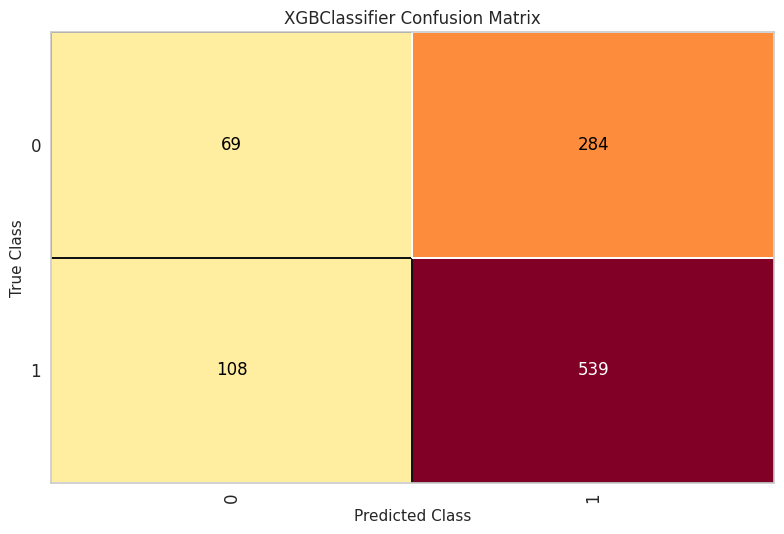

In [150]:

# model_xgb = XGBClassifier(objective='binary:logistic',  random_state=42)

# model_xgb.fit(x_train, y_train)

# y_pred = model_xgb.predict(x_test)

# model_evaluation(y_pred,y_test,y_train,x_train,x_test,model_xgb)

In [151]:
# param_grid = {
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 4, 5],
# }
# xgb_model = XGBClassifier()

# # Crie um objeto GridSearchCV
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5)

# # Ajuste o modelo aos dados de treinamento
# grid_search.fit(x_train, y_train)

# # Obtenha os melhores hiperparâmetros encontrados
# best_params = grid_search.best_params_

# # Obtenha o modelo com os melhores hiperparâmetros
# best_xgb_model = grid_search.best_estimator_

# # Faça previsões no conjunto de teste
# y_pred = best_xgb_model.predict(x_test)

# # Avalie o desempenho do modelo
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Acurácia no conjunto de teste: {accuracy:.4f}')

# # Exiba os melhores hiperparâmetros encontrados
# print("Melhores hiperparâmetros:")
# print(best_params)

In [152]:
# X.columns

Index(['tempo_de_assinatura', 'historico_de_presenca_nos_jogos',
       'historico_de_socio', 'numero_de_desistencias_no_periodo',
       'historico_de_preco_nos_planos', 'quantos_membros',
       'feedback_sobre_servicos', 'frequencia_de_compra_de_produtos',
       'recorrencia', 'tipo_de_plano_familiar', 'tipo_de_plano_individual',
       'planos_com_ingresso_incluso_nao', 'planos_com_ingresso_incluso_sim',
       'estado_civil_casado', 'estado_civil_divorciado',
       'estado_civil_solteiro', 'tipo_pagamento_boleto',
       'tipo_pagamento_cartão de crédito', 'tipo_pagamento_cartão de débito',
       'tipo_pagamento_pix', 'renda_mensal_0-1500', 'renda_mensal_10001-20000',
       'renda_mensal_1501-2500', 'renda_mensal_20001+',
       'renda_mensal_2501-5000', 'renda_mensal_5001-10000', 'cluster'],
      dtype='object')

In [153]:
# pca = PCA()
# X_pca = pca.fit_transform(X)

# # Retrieve the explained variance ratio for each principal component
# explained_variance_ratio = pca.explained_variance_ratio_

# # Create a DataFrame to store principal component, explained variance ratio, and corresponding feature names
# df_var_exp = pd.DataFrame({'Principal Component': range(1, len(explained_variance_ratio) + 1),
#                             'Explained Variance Ratio': explained_variance_ratio,
#                             'Feature': X.columns})

# # Create a bar plot to visualize the explained variance of each principal component with feature names
# plt.figure(figsize=(12, 8))
# bars = plt.bar(df_var_exp['Principal Component'], df_var_exp['Explained Variance Ratio'], color='blue', alpha=0.7)

# # Add feature names as labels to the bars
# for bar, feature in zip(bars, df_var_exp['Feature']):
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, feature, ha='center', va='bottom', rotation=45, fontsize=8)

# # Set plot labels and title
# plt.xlabel('Principal Component')
# plt.ylabel('Explained Variance Ratio')
# plt.title('Explained Variance of Principal Components with Feature Names')
# plt.show()

In [154]:
# X.drop(['estado_civil_divorciado',
#        'estado_civil_solteiro', 'cluster'], axis=1,inplace=True)

In [155]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

Acuracy: 0.6080. (The overall percentage of correct predictions made by the model)
Precision: 0.6736(The ratio of correct positive predictions to the total positive predictions made by the model)
Recall: 0.8133 (The ratio of correct positive predictions to the total actual positive cases.)
F1-score: 0.7369 ( A metric that combines precision and recall into a single measure, useful when there is an imbalance between classes)


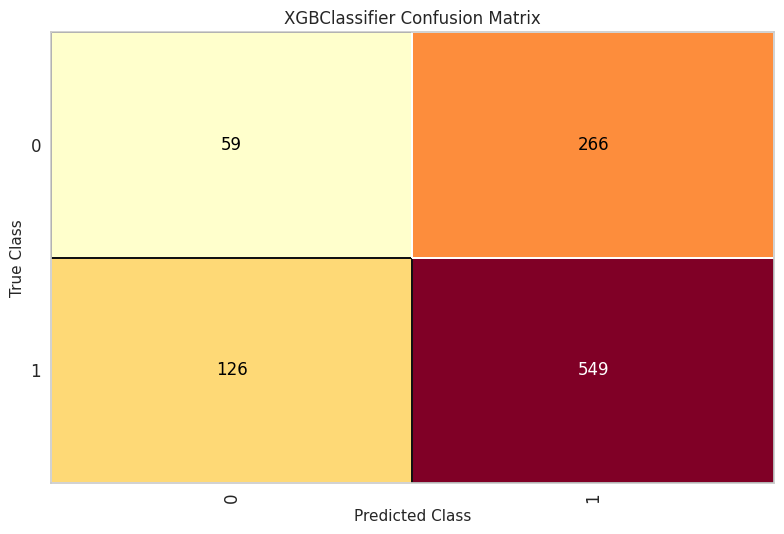

In [156]:

# model_xgb = XGBClassifier(objective='binary:logistic',  random_state=42)

# model_xgb.fit(x_train, y_train)

# y_pred = model_xgb.predict(x_test)

# model_evaluation(y_pred,y_test,y_train,x_train,x_test,model_xgb)

In [157]:
# param_grid = {
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 4, 5],
# }
# xgb_model = XGBClassifier()

# # Crie um objeto GridSearchCV
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5)

# # Ajuste o modelo aos dados de treinamento
# grid_search.fit(x_train, y_train)

# # Obtenha os melhores hiperparâmetros encontrados
# best_params = grid_search.best_params_

# # Obtenha o modelo com os melhores hiperparâmetros
# best_xgb_model = grid_search.best_estimator_

# # Faça previsões no conjunto de teste
# y_pred = best_xgb_model.predict(x_test)

# # Avalie o desempenho do modelo
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Acurácia no conjunto de teste: {accuracy:.4f}')

# # Exiba os melhores hiperparâmetros encontrados
# print("Melhores hiperparâmetros:")
# print(best_params)

In [235]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

In [159]:
# X = df.drop(['risco_de_churn','_id'], axis=1)
# y=df['risco_de_churn']


In [160]:
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [236]:
# Define a column selector for columns with dtype float64
num_col = make_column_selector(dtype_include=['float64', 'int64'])

# Define a column selector for columns excluding float64 (categorical columns)
cat_col = make_column_selector(dtype_exclude=['float64'])

# Create a column transformer with preprocessing steps
preproc = make_column_transformer(
    (RobustScaler(), num_col),    # Scale numerical columns using RobustScaler
    (OneHotEncoder(handle_unknown='ignore'), cat_col),  # Encode categorical columns using OrdinalEncoder
    remainder='passthrough'        # Pass through columns not specified in the num_col or cat_col
)

# Create a pipeline with the defined preprocessing and Logistic Regression as the estimator
pipe = make_pipeline(preproc, XGBClassifier(objective='binary:logistic' , random_state=42))

In [162]:
# pipe.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('robustscaler',
                                                  RobustScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd422373010>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd422372da0>)])),
                ('x...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_to_onehot=None,
 

In [163]:
# pipe.named_steps.items()

dict_items([('columntransformer', ColumnTransformer(remainder='passthrough',
                  transformers=[('robustscaler', RobustScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd422373010>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd422372da0>)])), ('xgbclassifier', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,

In [164]:
# x_train

,tempo_de_assinatura,historico_de_presenca_nos_jogos,historico_de_socio,numero_de_desistencias_no_periodo,historico_de_preco_nos_planos,tipo_de_plano,quantos_membros,planos_com_ingresso_incluso,estado_civil,feedback_sobre_servicos,frequencia_de_compra_de_produtos,tipo_pagamento,recorrencia,renda_mensal
2669,33,54,36,7,143,familiar,7,sim,casado,6,0,cartão de crédito,True,0-1500
1190,7,33,7,1,319,individual,6,nao,divorciado,1,7,cartão de crédito,True,1501-2500
325,9,36,11,3,129,individual,3,sim,divorciado,8,8,cartão de débito,True,2501-5000
2280,13,56,4,4,142,individual,4,sim,solteiro,0,5,cartão de crédito,True,0-1500
4685,30,59,3,0,251,familiar,6,sim,divorciado,7,9,pix,False,1501-2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4837,50,42,8,8,170,familiar,3,sim,divorciado,5,7,boleto,False,1501-2500
2135,80,49,21,7,194,individual,4,sim,solteiro,1,3,pix,False,1501-2500
1383,58,61,28,2,290,familiar,5,sim,divorciado,9,3,cartão de crédito,True,2501-5000
4752,84,16,9,2,146,individual,3,nao,divorciado,5,6,pix,False,2501-5000


In [237]:
pipe.fit(x_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('robustscaler',
                                                  RobustScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd4226b91e0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd4226b9150>)])),
                ('x...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=42, reg_alpha=0,
                               reg_lambda=1, ...))])

In [166]:
# x_test.dtypes

tempo_de_assinatura                   int64
historico_de_presenca_nos_jogos       int64
historico_de_socio                    int64
numero_de_desistencias_no_periodo     int64
historico_de_preco_nos_planos         int64
tipo_de_plano                        object
quantos_membros                       int64
planos_com_ingresso_incluso          object
estado_civil                         object
feedback_sobre_servicos               int64
frequencia_de_compra_de_produtos      int64
tipo_pagamento                       object
recorrencia                            bool
renda_mensal                         object
dtype: object

In [238]:
y_pred = pipe.predict(x_test)

In [239]:
param_grid = {
    'xgbclassifier__learning_rate': [0.1, 0.01, 0.001],
    'xgbclassifier__n_estimators': [100, 200, 300],
    'xgbclassifier__max_depth': [3, 4, 5],
}

# Crie um objeto GridSearchCV
grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring='accuracy', cv=5)

# Ajuste o modelo aos dados de treinamento
grid_search.fit(x_train, y_train)

# Obtenha os melhores hiperparâmetros encontrados
best_params = grid_search.best_params_

# Obtenha o modelo com os melhores hiperparâmetros
best_xgb_model = grid_search.best_estimator_

# Faça previsões no conjunto de teste
y_pred = best_xgb_model.predict(x_test)

# Avalie o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia no conjunto de teste: {accuracy:.4f}')

# Exiba os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:")
print(best_params)

Acurácia no conjunto de teste: 0.6510
Melhores hiperparâmetros:
{'xgbclassifier__learning_rate': 0.001, 'xgbclassifier__max_depth': 4, 'xgbclassifier__n_estimators': 300}


In [240]:
modelo = grid_search.best_estimator_
modelo

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('robustscaler',
                                                  RobustScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd4226e8640>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd4226ea710>)])),
                ('x...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.001, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=4, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=300, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=42, reg_alpha=0,
                               reg_lambda=1, ...))])

In [241]:
import joblib

model_path = '../model/model.pkl'
joblib.dump(modelo, model_path)


['../model/model.pkl']

In [242]:
df

,_id,tempo_de_assinatura,historico_de_presenca_nos_jogos,historico_de_socio,numero_de_desistencias_no_periodo,historico_de_preco_nos_planos,tipo_de_plano,quantos_membros,planos_com_ingresso_incluso,estado_civil,...,feedback_sobre_servicos,frequencia_de_compra_de_produtos,tipo_pagamento,recorrencia,renda_mensal,aprovacao_cartao,CAC,LTV,expected_payments,ROI
0,2,52,60,1,1,219,familiar,3,sim,divorciado,...,1,3,pix,False,2501-5000,VERDADEIRO,3.014901,1138.8,284.7,376.723792
1,3,29,20,4,3,435,individual,4,nao,casado,...,4,5,pix,False,1501-2500,VERDADEIRO,2.995852,1261.5,1566.0,420.082206
2,5,43,86,3,3,239,individual,1,sim,casado,...,8,2,boleto,False,0-1500,VERDADEIRO,3.019431,1027.7,525.8,339.362180
3,20,54,73,30,8,112,individual,6,sim,divorciado,...,7,8,cartão de crédito,True,0-1500,VERDADEIRO,3.045691,604.8,123.2,197.575634
4,24,52,15,27,6,111,individual,7,sim,casado,...,7,4,cartão de débito,True,2501-5000,VERDADEIRO,2.992975,577.2,144.3,191.851568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,4989,75,74,4,9,289,familiar,5,sim,solteiro,...,0,0,boleto,False,1501-2500,TRUE,2.980279,2167.5,-289.0,726.280945
4995,4992,64,23,12,8,447,familiar,7,nao,casado,...,2,1,cartão de crédito,True,2501-5000,TRUE,2.998531,2860.8,44.7,953.067159
4996,4994,8,9,20,5,271,familiar,2,sim,divorciado,...,4,6,pix,False,0-1500,TRUE,3.021342,216.8,1544.7,70.756186
4997,4995,25,55,31,0,263,individual,5,sim,divorciado,...,4,3,cartão de débito,True,1501-2500,FALSE,3.093387,657.5,1052.0,211.550171


In [175]:
novos = pd.read_csv('../data/customers.csv')

In [176]:
novos.head()

,id,name,team_id,email,tempo_de_assinatura,historico_de_presenca_nos_jogos,historico_de_socio,numero_de_desistencias_no_periodo,historico_de_preco_nos_planos,tipo_de_plano,quantos_membros,planos_com_ingresso_incluso,estado_civil,risco_de_churn,feedback_sobre_servicos,frequencia_de_compra_de_produtos,created_at,updated_at
0,1629,Donn Ratke,1,roy_koss@brakus.test,55,48,4,6,397,individual,1,f,casado,NaN,2,8,2024-02-17 00:32:37 UTC,2024-02-17 00:32:37 UTC
1,1630,Agustin Shields MD,1,marlon@kling.test,82,54,20,8,85,individual,3,t,casado,NaN,6,5,2024-02-17 00:32:37 UTC,2024-02-17 00:32:37 UTC
2,1631,Sherley Ryan,1,lorraine_braun@rowe-stroman.example,52,10,32,0,63,familiar,4,t,divorciado,NaN,9,9,2024-02-17 00:32:37 UTC,2024-02-17 00:32:37 UTC
3,1632,Carlton Borer,1,gladys@cassin.test,16,63,4,9,172,individual,7,t,divorciado,NaN,7,5,2024-02-17 00:32:37 UTC,2024-02-17 00:32:37 UTC
4,1633,Demetrius Marks,1,sherell@collier.example,73,12,2,1,145,individual,6,f,solteiro,NaN,8,3,2024-02-17 00:32:37 UTC,2024-02-17 00:32:37 UTC


In [177]:
df.columns

Index(['_id', 'tempo_de_assinatura', 'historico_de_presenca_nos_jogos',
       'historico_de_socio', 'numero_de_desistencias_no_periodo',
       'historico_de_preco_nos_planos', 'tipo_de_plano', 'quantos_membros',
       'planos_com_ingresso_incluso', 'estado_civil', 'risco_de_churn',
       'feedback_sobre_servicos', 'frequencia_de_compra_de_produtos',
       'tipo_pagamento', 'recorrencia', 'renda_mensal'],
      dtype='object')

In [178]:
novos.columns

Index(['id', 'name', 'team_id', 'email', 'tempo_de_assinatura',
       'historico_de_presenca_nos_jogos', 'historico_de_socio',
       'numero_de_desistencias_no_periodo', 'historico_de_preco_nos_planos',
       'tipo_de_plano', 'quantos_membros', 'planos_com_ingresso_incluso',
       'estado_civil', 'risco_de_churn', 'feedback_sobre_servicos',
       'frequencia_de_compra_de_produtos', 'created_at', 'updated_at'],
      dtype='object')

### Modelo de previsão de tempo de permanência

In [184]:
df.describe()

,_id,tempo_de_assinatura,historico_de_presenca_nos_jogos,historico_de_socio,numero_de_desistencias_no_periodo,historico_de_preco_nos_planos,quantos_membros,risco_de_churn,feedback_sobre_servicos,frequencia_de_compra_de_produtos,LTV,expected_payments
count,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000
mean,2500.000000,43.770754,37.954991,18.378076,4.506901,248.821164,3.999000,0.661932,4.985197,5.608722,1086.167754,531.169814
std,1443.231328,25.126241,21.265076,11.062298,2.873953,143.803688,2.007339,0.473099,3.133961,4.279236,951.862853,785.696934
min,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.600000,-1095.600000
25%,1250.500000,22.000000,20.000000,9.000000,2.000000,126.000000,2.000000,0.000000,2.000000,2.000000,301.400000,0.000000
50%,2500.000000,43.000000,38.000000,18.000000,5.000000,247.000000,4.000000,1.000000,5.000000,5.000000,816.000000,323.100000
75%,3749.500000,65.000000,57.000000,28.000000,7.000000,373.000000,6.000000,1.000000,8.000000,8.000000,1656.850000,976.500000
max,4999.000000,87.000000,86.000000,37.000000,9.000000,500.000000,7.000000,1.000000,10.000000,20.000000,4332.600000,3187.200000


In [217]:
from pulp import LpProblem, LpVariable, LpMaximize, lpSum

def otimizar_retencao(df):
    # Filtre usuários com mais de 70% de probabilidade de sair
    df_retencao = df[df['prob_de_churn'] > 0.7]

    # Definir o problema de otimização
    model = LpProblem(name="otimizacao_retencao_usuarios", sense=LpMaximize)

    # Variáveis de decisão representando o investimento para reter cada usuário
    investir_retentor = LpVariable.dicts("Investir_Retentor", df_retencao.index, lowBound=0)

    # Função objetivo - maximizar a soma da função desejada para cada usuário
    model += lpSum(df_retencao['LTV'][i] + df_retencao['expected_payments'][i] - df_retencao['CAC'][i] - investir_retentor[i] for i in df_retencao.index)

    # Restrição: o investimento deve ser maior que 10% de (LTV - CAC) para cada usuário
    for i in df_retencao.index:
        model += investir_retentor[i] >= 0.1 * (df_retencao['LTV'][i] - df_retencao['CAC'][i])

    # Restrição: o churn final deve ser inferior ao prob_de_churn para cada usuário
    for i in df_retencao.index:
        model += (df_retencao['prob_de_churn'][i] - 0.01 * investir_retentor[i]) >= 0

    # Restrição: churn final deve estar entre 0.5 e 0.7 para cada usuário
    for i in df_retencao.index:
        model += 0.5 <= (df_retencao['prob_de_churn'][i] - 0.01 * investir_retentor[i]) <= 0.7

    # Resolver o problema de otimização
    model.solve()

    # Adicionar colunas 'investimento_mkt' e 'churn_final' ao DataFrame original
    df['investimento_mkt'] = 0.0
    df['churn_final'] = 0.0

    # Preencher os valores nas colunas correspondentes
    for i in df_retencao.index:
        df.at[i, 'investimento_mkt'] = investir_retentor[i].value()
        df.at[i, 'churn_final'] = df_retencao['prob_de_churn'][i] - 0.01 * investir_retentor[i].value()

    # Exibir resultados
    print("Status:", model.status)

    # Mostrar decisões de investimento para cada usuário
    for i in df_retencao.index:
        print(f"Usuário {i}: Investir = {investir_retentor[i].value()}")

    # Mostrar resultado da função objetivo
    resultado = sum(df_retencao['LTV'][i] + df_retencao['expected_payments'][i] - df_retencao['CAC'][i] - investir_retentor[i].value() for i in df_retencao.index)
    print("Resultado da função objetivo:", resultado)

# Exemplo de uso com um DataFrame fictício
import pandas as pd

dados = {
    'LTV': [1000, 1200, 800],
    'CAC': [200, 250, 150],
    'expected_payments': [500, 600, 400],
    'prob_de_churn': [0.8, 0.9, 0.7]
}

df_exemplo = pd.DataFrame(dados)

# Chamar a função otimizar_retencao com o DataFrame de exemplo
otimizar_retencao(X_novo)

# Exibir o DataFrame resultante
X_novo[X_novo['prob_de_churn'] > 0.7]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/giovane/.pyenv/versions/lewagon/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/c67204daf1a8431eabaf505260e35ee9-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/c67204daf1a8431eabaf505260e35ee9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 116 COLUMNS
At line 265 RHS
At line 377 BOUNDS
At line 378 ENDATA
Problem MODEL has 111 rows, 37 columns and 111 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve determined that the problem was infeasible with tolerance of 1e-08
Analysis indicates model infeasible or unbounded
Perturbing problem by 0.001% of 1 - largest nonzero change 2.0069971e-05 ( 0.0020069971%) - largest zero change 0
0  Obj -0 Primal inf 319.37186 (56)
17  Obj -266.62046 Primal inf 35.374012 (23)
Primal infeasible - objective value -266.62046
PrimalInfeasib

,tempo_de_assinatura,historico_de_presenca_nos_jogos,historico_de_socio,numero_de_desistencias_no_periodo,historico_de_preco_nos_planos,tipo_de_plano,quantos_membros,planos_com_ingresso_incluso,estado_civil,feedback_sobre_servicos,...,tipo_pagamento,recorrencia,renda_mensal,LTV,expected_payments,CAC,ROI,prob_de_churn,investimento_mkt,churn_final
430,8,55,2,9,172,familiar,5,nao,casado,8,...,pix,False,2501-5000,137.6,980.4,176.334830,-0.219666,0.718362,0.000000,0.718362
548,8,13,31,8,145,familiar,4,nao,solteiro,9,...,pix,False,0-1500,116.0,826.5,207.422917,-0.440756,0.704919,0.000000,0.704919
783,8,57,37,8,77,individual,4,nao,casado,1,...,boleto,False,2501-5000,61.6,438.9,212.211715,-0.709724,0.701787,0.000000,0.701787
971,8,33,28,2,83,individual,5,sim,solteiro,8,...,cartão de débito,True,1501-2500,66.4,473.1,186.378967,-0.643737,0.718040,0.000000,0.718040
999,68,71,19,5,140,familiar,7,nao,solteiro,0,...,cartão de crédito,True,0-1500,952.0,-42.0,211.451656,3.502211,0.702116,74.054834,-0.038432
1043,8,24,21,0,100,familiar,1,nao,solteiro,8,...,pix,False,1501-2500,80.0,570.0,199.229831,-0.598454,0.722077,0.000000,0.722077
1438,8,51,18,3,203,familiar,2,sim,casado,4,...,boleto,False,1501-2500,162.4,1157.1,209.819499,-0.226001,0.707507,0.000000,0.707507
1715,8,60,33,7,100,individual,3,sim,solteiro,3,...,cartão de débito,True,1501-2500,80.0,570.0,198.189334,-0.596346,0.714111,0.000000,0.714111
1855,8,24,19,0,446,familiar,4,nao,casado,7,...,cartão de débito,True,1501-2500,356.8,2542.2,186.587596,0.912239,0.718362,17.021240,0.548150
2050,8,17,0,0,118,individual,1,sim,divorciado,8,...,cartão de crédito,True,1501-2500,94.4,672.6,216.501965,-0.563976,0.709432,0.000000,0.709432
